# Advanced Lane Finding

## Writeup Template

---

#### All imports 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import matplotlib.image as mpim
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### Reading imges

In [2]:
#reading in images
def loadImages(ip_folder):
    imagesList = os.listdir(ip_folder)
    loadedImages = []
    for image in imagesList:
        img = mpimg.imread(ip_folder + image)
        img = np.array(img)
        loadedImages.append(img)
    return loadedImages

# Read test images
test_images = loadImages('test_images\\')

#### Camera calibration

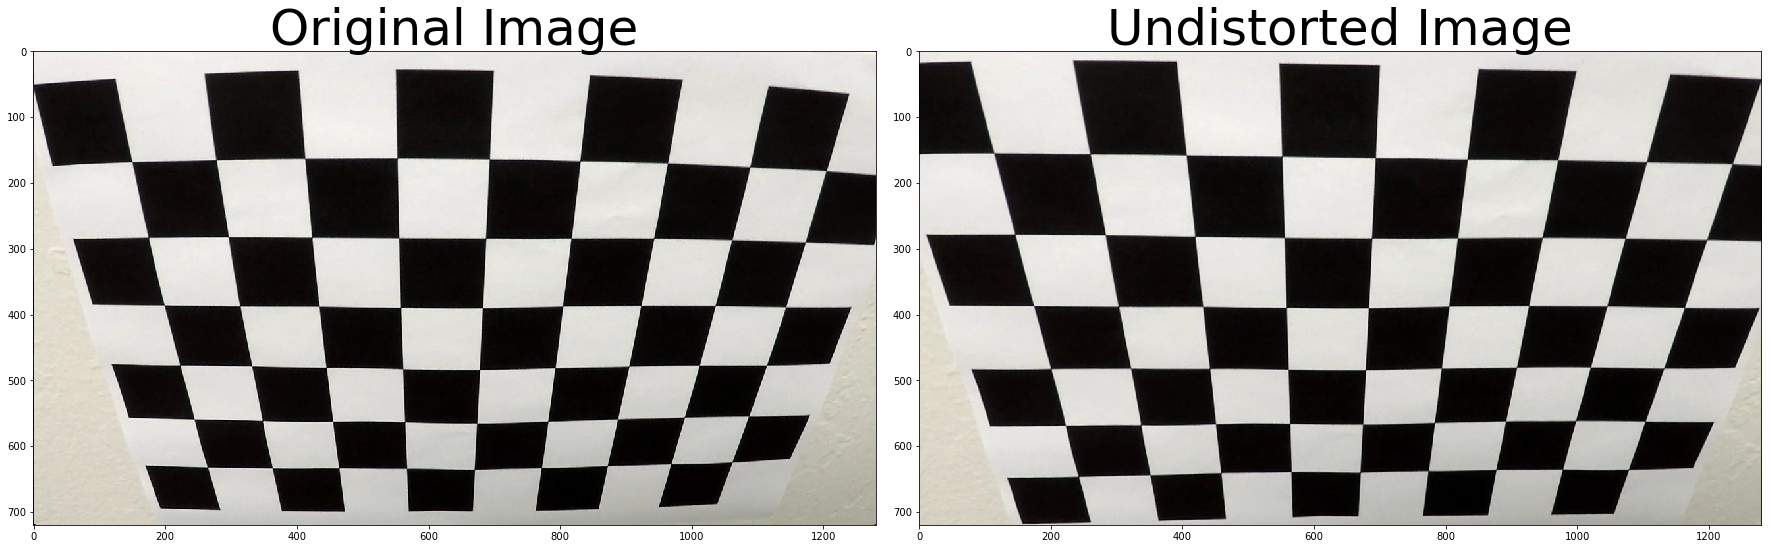

In [3]:
# Reaed camera calibration images
cam_cal = loadImages('camera_cal\\')

nx = 9
ny = 6
obj_points = []  # 3D points in the real world space
img_points = []  # 2D points in the image
objp = np.zeros((nx * ny, 3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
mtx_list = []
dist_list = []

# camera calibration for all images
for img in cam_cal:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    
        img_points.append(corners)
        obj_points.append(objp)
    
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)
        mtx_list.append(mtx)
        dist_list.append(dist)
        
# clacualte the average for all readings
mtx = sum(mtx_list) / float(len(mtx_list))
dist = sum(dist_list) / float(len(dist_list))
del(dist_list)
del(mtx_list)
img = plt.imread(os.path.join('camera_cal', 'calibration2.jpg'))

#show an example of an undustorted picture
undist = cv2.undistort(img, mtx, dist, None, mtx)            
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Images processing to prepare for detection

In [4]:
def undistort(img):
    ''' undistort an image'''
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return  undist

def warper(img, f=True):
    ''' get the perspe3ctive transform if an image'''
    #            [bottom_left,bottom_right,top_right,top_left]
    pts = np.array([[100,720], [1100,720], [1200,0], [80,0]])
    destination = np.float32(pts.tolist())
    #            ([bottom_left,bottom_right,top_right, top_left])
    pts = np.array([[100,720], [1310,720], [717, 450], [580,450]]) 
    source = np.float32(pts.tolist())
    if f == True:
        M = cv2.getPerspectiveTransform(source, destination)
    else:
        M = cv2.getPerspectiveTransform(destination, source)

    image_size = (img.shape[1], img.shape[0])
    
    return cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)

def color_selection(img):
    ''' color filter for white and yellow pixels'''
    yellow_p = np.copy(img)
    white_p = np.copy(img)

    thresholds_white = (img[:,:,2] < 193)
    thresholds_yellow = (img[:,:,0] < 225) | (img[:,:,1] < 175)
        
    white_p[thresholds_white] = [0,0,0]
    yellow_p[thresholds_yellow] = [0,0,0]
        
    img = cv2.add(white_p, yellow_p)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
    return img

def abs_sobel_thresh(img, sobel_kernel=3, thresh=(0, 255)):    
    abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return grad_binary

def in_sobel(img):
    '''calculate the gradient'''
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = abs_sobel_thresh(img, thresh=(30, 150))
    return gradx

#### Line detection function

In [5]:
def lines(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    img_out = np.dstack((img, img, img)) * 255
    # Find the peak of the left and right halves of the histogram These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & \
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & \
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    mid = (np.array(left_fit) + np.array(right_fit)) / 2
    #-------------------------------------------------------------------------------------------------------------
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] #+ 50
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2] #+ 50
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the blank image
    cv2.fillPoly(img_out, np.int_([pts]), (60,255, 60))

    img_out[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    img_out[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    #-------------------------------------------------------------------------------------------------------------    
    ym_per_pix = 30/720 #15/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 #7.4/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / \
                    np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) /\
                    np.absolute(2 * right_fit_cr[0])
    curvature = abs(left_curverad + right_curverad) / 2
    
    # Calculate position from center
    camera_center = img.shape[0] / 2
    lane_center = (left_fitx[719] + right_fitx[719]) / 2
    pos_to_center = abs(camera_center - lane_center + 200) * xm_per_pix
    
    return img_out,curvature, pos_to_center

#### Pipeline

In [6]:
def process_image(img):
    undistorted = undistort(img)
    sobled = in_sobel(img)
    warped_sobled = warper(sobled)
    warped_img = warper(img)
    color_selected = color_selection(warped_img)
    added = cv2.addWeighted(warped_sobled, 1, color_selected, 1, 0, 8)
    ret, added = cv2.threshold(added, 0, 10, cv2.THRESH_BINARY)
    lined, curv, pos = lines(added)
    rewarped_lines = warper(lined, False)
    cv2.putText(rewarped_lines, 'Radius of Curvature: %.5f m' % curv, (5, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 6)
    cv2.putText(rewarped_lines, 'Position from Center: %.5f m' % pos, (5, 130), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 6)
    result = cv2.addWeighted(rewarped_lines, 0.6, img, 1, 0, 8)
    return result

#### Pipeline results on test images

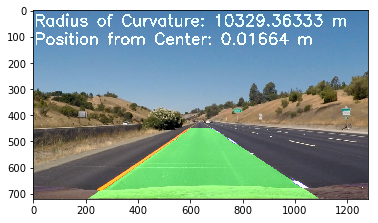

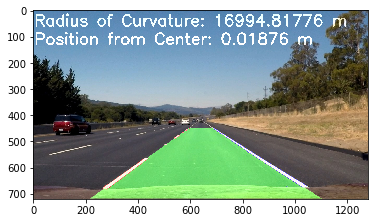

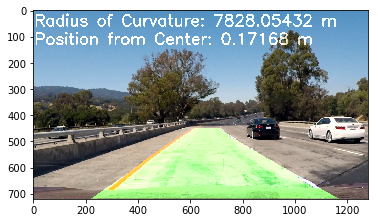

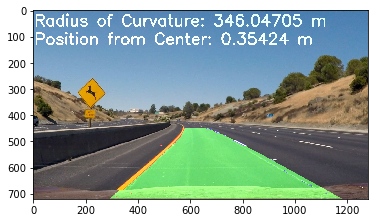

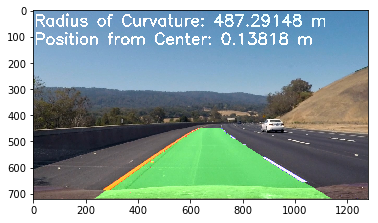

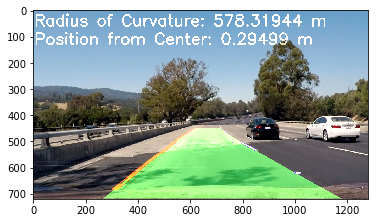

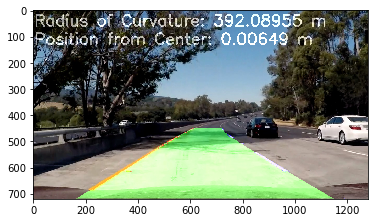

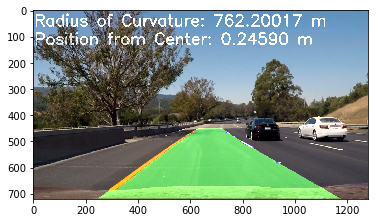

In [7]:
for img in test_images:
    img = process_image(img)
    plt.imshow(img)
    plt.show()

#### Video processing

In [8]:
vid_out = 'final.mp4'
vid = VideoFileClip('project_video.mp4')
vid_clip = vid.fl_image(process_image)
%time vid_clip.write_videofile(vid_out, audio=False)

HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(vid_out))

[MoviePy] >>>> Building video final.mp4
[MoviePy] Writing video final.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:22<00:00,  3.91it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: final.mp4 

Wall time: 5min 24s
